# Introduction to Denoising
## A Simple Gaussian Noise Model, and How to Use this Notebook
Welcome to the Computational Imaging portion of the workshop! This notebook (and several companion notebooks) will guide you through how to use the methods we explore in the workshop, along with giving you example implementations. The following two cells will make sure you have all the packages you need, and then make sure you can access some test images.

In [1]:
# Remove this after running for the first time
#!pip install pywavelets scikit-image pillow imageio matplotlib scipy

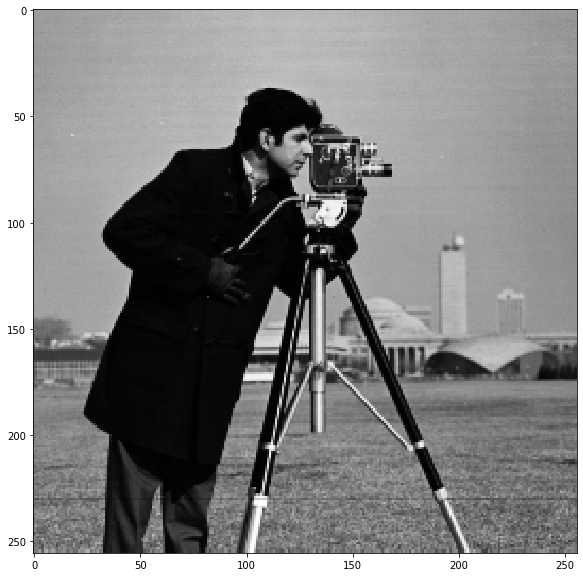

In [2]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10] # Tweak this if you want the plots to be smaller

cwd = os.getcwd()
image_folder = cwd + "/images/"

example_image_path = image_folder + "cameraman.jpg"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))
fig = plt.figure()
plt.imshow(test_image, cmap='gray')
plt.show()

### Noise Model
Our noise model for the rest of the denoising module is the following:
$$y = x + \epsilon, \ \ \epsilon \sim \mathcal{N}(0, \sigma^2).$$
Some of the following methods assume you have access to $\sigma$, the noise standard deviation. Adding some noise to the above image might look like:

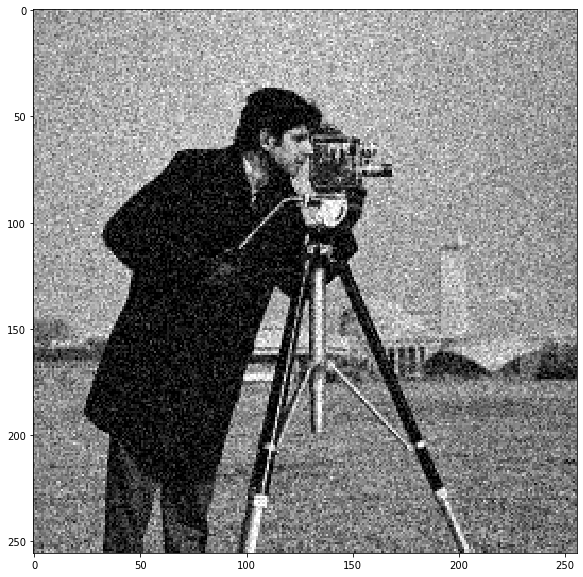

In [3]:
import corruption_models, plotting_utils
# Note that this method will clip the image to ensure it stays between 0 and 1.
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=0.1)
fig = plt.figure()
plt.imshow(noisy_image, cmap='gray')
plt.show()

## Gaussian Filtering
In this section, we explore using a simple Gaussian filter for denoising.

A Gaussian filter is a very simple low-pass filter which is easy to implement, and easy to understand. It's also related to some methods we'll use later, like bilateral filtering. First we create a function to generate Gaussian filter weights:

In [4]:
from scipy.signal import convolve2d
def gaussian_filter_coeffs(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

Then applying the filter is as simple as a single convolution. Try adjusting the filter parameters to explore the effect of the filter width and falloff. A very large filter stdev will approximate a boxcar, or averaging, filter.

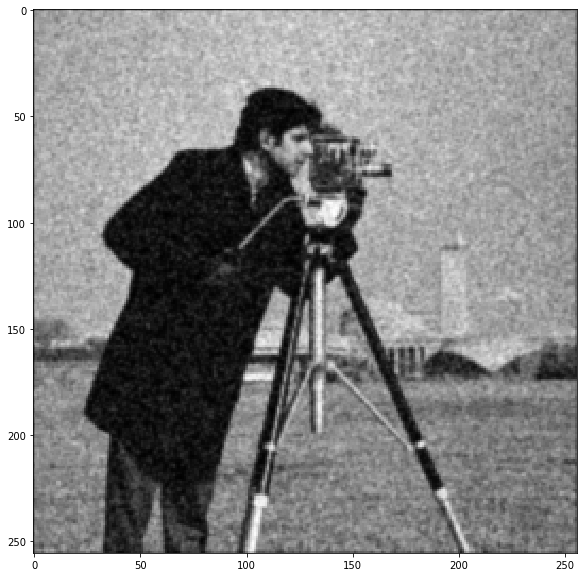

In [5]:
# Try tweaking these
filter_width = 10
filter_stdev = 0.7
gaussian_filter = gaussian_filter_coeffs(size=filter_width, sigma=filter_stdev)
filtered_image = convolve2d(noisy_image, gaussian_filter, mode='same')

fig = plt.figure()
plt.imshow(filtered_image, cmap='gray')
plt.show()

### Bilateral Filtering Overview
Hopefully you've been able to explore the relationship between removing noise and keeping edges in the original image - linear filtering like above will blur the entire image, noise and edges alike.

Remember the core idea behind bilateral filtering: when we filter, we want to not only base the filter weights on distance from the center pixel, but also on some information about their similarity. For greyscale images, this might correspond to intensity, while for color images this is slightly more complicated. By doing this, we hope that we only blur the parts that are noisy, but keep large jumps in intensity intact.

Below we have implemented bilateral filtering, and demonstrate its use on the cameraman greyscale image. You may find it interesting to experiment with other test images. Recall the motivation for bilateral filtering - we'd like to maintain sharp edges between differently-colored regions. You should notice that at very low noise levels this does quite well, whereas with higher noise it's very hard to get right.

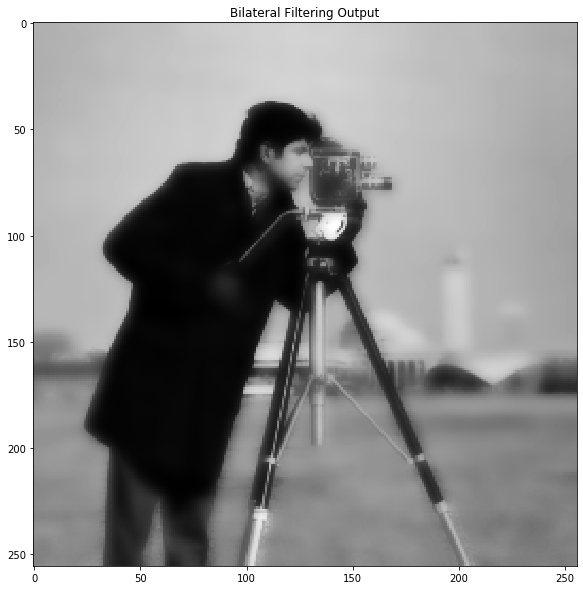

In [6]:
from bilateral_filtering import bilateral_filter
sigma_r = 0.4
sigma_d = 3
filter_width = 11
noise_sigma = 0.01
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)
greyscale_image_reconstruction = bilateral_filter(noisy_image, sigma_r=sigma_r, sigma_d=sigma_d, filter_width=filter_width)

# fig = plt.figure()
# plt.imshow(noisy_image, cmap='gray'); plt.title("Noisy Greyscale Image")
fig = plt.figure()
plt.imshow(greyscale_image_reconstruction, cmap='gray'); plt.title("Bilateral Filtering Output")
plt.show()

## Non-local Means
After experimenting with the above, you likely encountered the largest issue with bilateral filtering: large noise $\sigma$ can cause problems that just can't be eliminated. Part of the problem is that bilateral filtering trieds to find continguous regions based only on noisy individual pixel values. If the noise is high, then this estimate can be quite inaccurate!

Non-local means weights the similarity of a pixels based on the similarity of the *patches around the pixels*. By calculating similarity by patch similarity, we try to average out the noise effects just mentioned. All the same, you may notice that as you make your window larger, edges will accumulate artifacts.

Try it out below! Because non-local means can take quite a while to run if non-optimized, we use built-in methods from skimage.

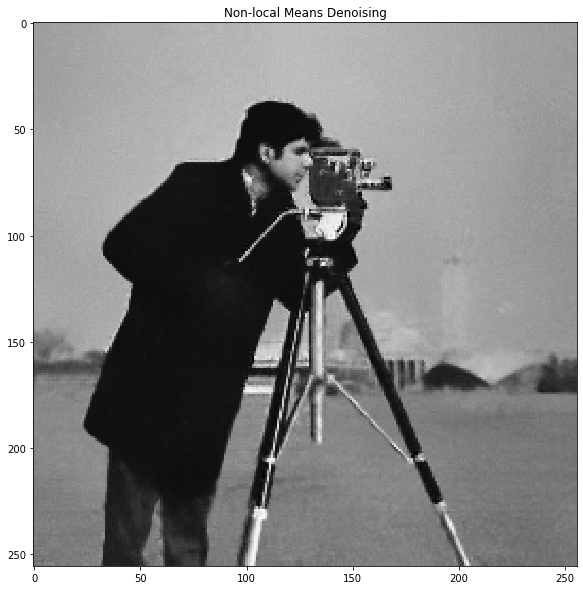

In [7]:
from skimage import restoration
import corruption_models, plotting_utils

example_image_path = image_folder + "cameraman.jpg"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))

noise_sigma = 0.1
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)

patch_size = 5 # How large of patches do we use for filtering
patch_distance = 11 # How far away from the center pixel should we search for patches
multichannel = False # Change to True if you want to use for color images
cutoff_parameter = 0.05 # How similar should the patches be in order to use them for denoising
# A good default is to set this to be around noise_sigma - experiment!
restored_image = restoration.denoise_nl_means(noisy_image, patch_size=patch_size, patch_distance=patch_distance, multichannel=multichannel, )

fig = plt.figure()
plt.imshow(restored_image, cmap='gray'); plt.title('Non-local Means Denoising')
plt.show()

### Bilateral filtering in color
We have only discussed denoising grayscale images so far, but it is possible to use all these methods with color images as well. In fact, the code in bilateral_filtering.py has already implemented a filtering scheme for color images.

In greyscale bilateral filtering, we weight the contributions of nearby pixels by their similarity in intensity to the pixel we're filtering. For color images, we have to weight the contributions by their similarity across all three color channels. Test it by modifying the code below: is this the same as applying the bilateral filter across each color channel separately? 

Let's load up a color image and try out the skimage method. Feel free to try out our handwritten code as well! It's used almost identically for greyscale images.

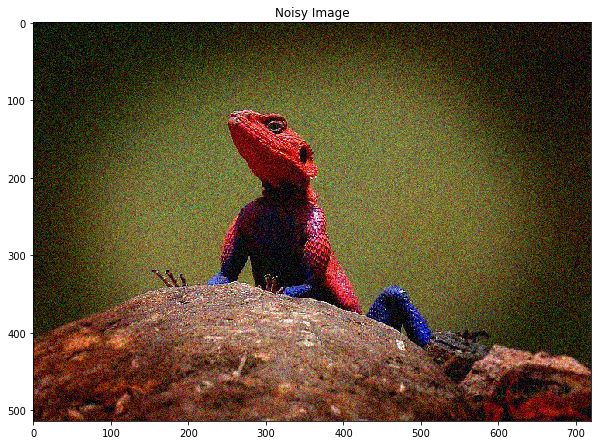

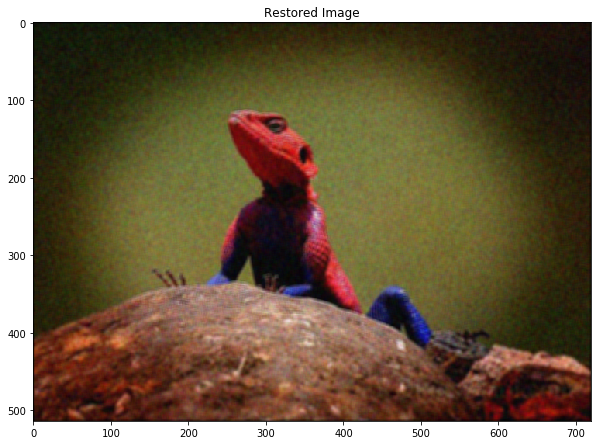

In [46]:
example_image_path_color = image_folder + "lizardRGB.jpg"
test_image_color = utils.normalize_to_01(imageio.imread(example_image_path_color))
noisy_image_color = corruption_models.add_gaussian_noise(test_image_color, sigma=0.1)

sigma_r = 0.05
sigma_d = 20
filter_width = 5

# Make sure to use multichannel=True !
# denoised_image_color = bilateral_filter(noisy_image, sigma_r=sigma_r, sigma_d=sigma_d, filter_width=filter_width)
denoised_image_color = restoration.denoise_bilateral(noisy_image_color, win_size=filter_width, sigma_color=sigma_r, sigma_spatial=sigma_d, multichannel=True)

fig = plt.figure()
plt.imshow(noisy_image_color); plt.title('Noisy Image')
fig = plt.figure()
plt.imshow(denoised_image_color); plt.title('Restored Image')
plt.show()

### Different Color Spaces
We didn't touch on this much, but an interesting variable to tweak when working with color images is the color space you're using. By default most images will be interpreted as RGB, so there's one channel for the red portion of the image, one for green, and one for blue. 

This is important because different color spaces have different properties. In particular, remember that bilateral filtering relies on calculating the difference in color between pixels. It turns out that the Euclidean distance between RGB channels isn't always the best way to do that. An interesting thing to try is to change what color space you're in when doing denoising, to try to look at the effects. Unfortunately we'll have to use our homemade method, as skimage requires RGB.

Some recommendations: try CieLab for bilateral filtering, and when we get to wavelet methods, try using YCbCr (note skimage will always convert RGB to YCbCr for wavelet denoising). We don't have time to get into what exactly these mean, but the wikipedia pages are pretty good!

The next cell will demonstrate how to convert colors, and then the final one will convert into a different color space, denoise, and then convert back to RGB for visualization purposes. Careful with parameter settings! Sometimes when you convert to a different space, you'll need to rescale your $\sigma_r$ parameter.

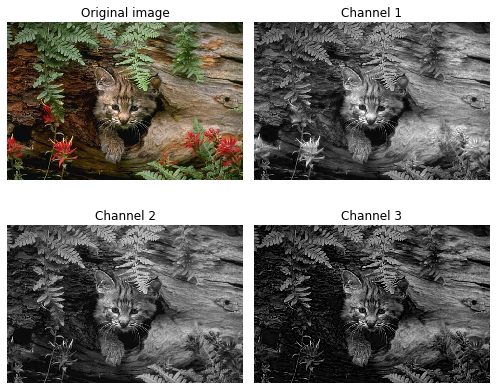

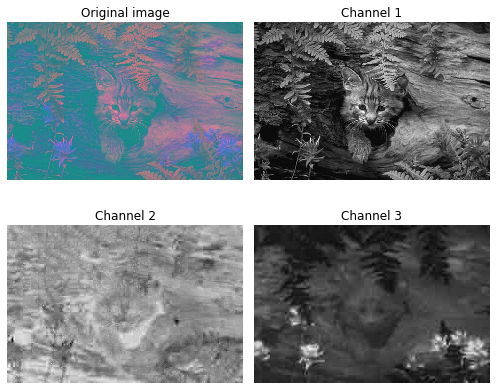

In [9]:
def channel_demonstration_plot(threechannel_image):
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(threechannel_image)
    ax[0].set_title("Original image")
    ax[1].imshow(threechannel_image[:, :, 0], cmap='gray'); ax[1].set_title("Channel 1")
    ax[2].imshow(threechannel_image[:, :, 1], cmap='gray'); ax[2].set_title("Channel 2")
    ax[3].imshow(threechannel_image[:, :, 2], cmap='gray'); ax[3].set_title("Channel 3")
    for a in ax.ravel():
        a.axis('off')
    fig.tight_layout()

from skimage import color
example_image_path_color = image_folder + "cat_in_tree.jpg"
test_image_color = utils.normalize_to_01(imageio.imread(example_image_path_color))

# imshow really wants channels' dynamic ranges to be from 0 to 1, so divide by around 100 for Lab, and 235 for Ycbcr
Lab_color_image = color.rgb2lab(test_image_color) / 100.
ycbcr_color_image = color.rgb2ycbcr(test_image_color) / 235.0

channel_demonstration_plot(test_image_color)
# Note that it also assumes we're in RGB!
channel_demonstration_plot(ycbcr_color_image)

# RGB channels generally carry the same information, whereas in Ycbcr and Lab, only the first channel
# will "look" like the original. 

In [10]:
noise_sigma = 0.1
example_image_path_color = image_folder + "maize.jpg"
test_image_color = utils.normalize_to_01(imageio.imread(example_image_path_color))
noisy_image_color = corruption_models.add_gaussian_noise(test_image_color, sigma=noise_sigma)

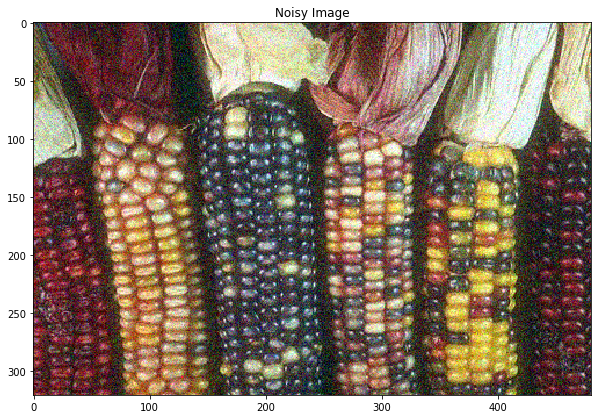

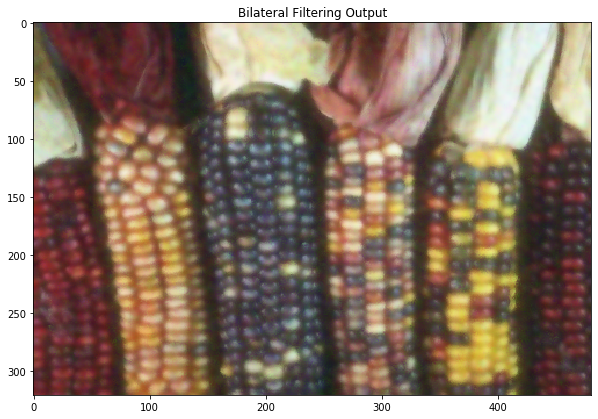

In [11]:
# Experiment with these! Try out nonlocal means with different color spaces as well!
sigma_r = 0.5
sigma_d = 2
filter_width = 5

noisy_image_Lab = color.rgb2lab(noisy_image_color); sigma_r *= 100 # Rescale your parameters for the new color space
# noisy_image_ycbcr = color.rgb2ycbcr(noisy_image_color); sigma_r *= 235.
# noisy_image_hsv = color.rgb2hsv(noisy_image_color); sigma_r *= 255
# noisy_image_xyz = color.rgb2xyz(noisy_image_color); sigma_r *= 100
sigma_r *= 100 # Rescale your parameters for the new color space
image_reconstruction = bilateral_filter(noisy_image_Lab, sigma_r=sigma_r, sigma_d=sigma_d, filter_width=filter_width)
image_reconstruction = color.lab2rgb(image_reconstruction)
fig = plt.figure()
plt.imshow(noisy_image_color)
plt.title("Noisy Image")
fig = plt.figure()
plt.imshow(image_reconstruction)
plt.title("Bilateral Filtering Output")

plt.show()